In [31]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.utils import resample
from sklearn.utils import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D,MaxPool2D
import tensorflow as tf

In [2]:
data_dir=r'C:\Users\om\Documents\example\chest_xray'
paths=glob.glob(data_dir+'/*/*/*.jpeg')
print(f'found {len(paths)} images in the dataset')
paths[:5]

found 5856 images in the dataset


['C:\\Users\\om\\Documents\\example\\chest_xray\\test\\NORMAL\\IM-0001-0001.jpeg',
 'C:\\Users\\om\\Documents\\example\\chest_xray\\test\\NORMAL\\IM-0003-0001.jpeg',
 'C:\\Users\\om\\Documents\\example\\chest_xray\\test\\NORMAL\\IM-0005-0001.jpeg',
 'C:\\Users\\om\\Documents\\example\\chest_xray\\test\\NORMAL\\IM-0006-0001.jpeg',
 'C:\\Users\\om\\Documents\\example\\chest_xray\\test\\NORMAL\\IM-0007-0001.jpeg']

In [3]:
df=pd.DataFrame(paths,columns=['path'])
df['label']=df['path'].apply(lambda x:x.split('\\')[7].strip())
df.head()

,path,label
0,C:\Users\om\Documents\example\chest_xray\test\...,NORMAL
1,C:\Users\om\Documents\example\chest_xray\test\...,NORMAL
2,C:\Users\om\Documents\example\chest_xray\test\...,NORMAL
3,C:\Users\om\Documents\example\chest_xray\test\...,NORMAL
4,C:\Users\om\Documents\example\chest_xray\test\...,NORMAL


In [4]:
counts=df['label'].value_counts()
counts

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

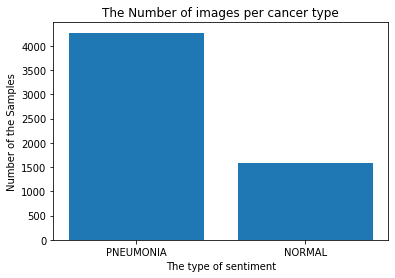

In [5]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.show()

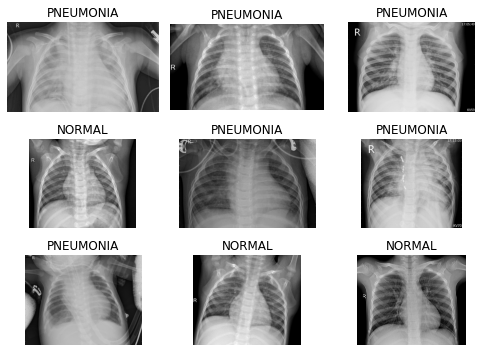

In [6]:
num_images=9
sampled_df = df.sample(n=num_images).reset_index(drop=True)
plt.figure(figsize=(7, 5))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)
    plt.imshow(img,cmap='gray')
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
df['label'] = df['label'].map({'NORMAL': '0', 'PNEUMONIA': '1'})

In [8]:
df['label'].value_counts()

label
1    4273
0    1583
Name: count, dtype: int64

In [9]:
df_majority = df[df.label == '1']
df_minority = df[df.label == '0']
df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority), random_state=42)  
df = pd.concat([df_minority, df_majority_downsampled])

In [10]:
df['label'].value_counts()

label
0    1583
1    1583
Name: count, dtype: int64

In [11]:
df=df.sample(frac=1.0, random_state=42)
df.head(5)

,path,label
954,C:\Users\om\Documents\example\chest_xray\train...,0
1720,C:\Users\om\Documents\example\chest_xray\train...,0
170,C:\Users\om\Documents\example\chest_xray\test\...,0
2434,C:\Users\om\Documents\example\chest_xray\train...,1
343,C:\Users\om\Documents\example\chest_xray\test\...,1


In [12]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Validation set shapes:", valid_df.shape)
print("Testing set shapes:", test_df.shape)

Training set shapes: (2532, 2)
Validation set shapes: (317, 2)
Testing set shapes: (317, 2)


In [13]:
train_df['label'].value_counts()

label
1    1277
0    1255
Name: count, dtype: int64

In [14]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
    shear_range=0.2,
    rotation_range=.1,
    zoom_range=0.2,       
    horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(150, 150), 
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(150, 150), 
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False  
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(150, 150),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='binary',
    shuffle=False  
)

Found 2532 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


In [15]:
classes=['NORMAL','PNEUMONIA']
classes

['NORMAL', 'PNEUMONIA']

In [16]:
train_generator.image_shape

(150, 150, 3)

In [17]:
from keras.applications import MobileNetV2
mobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in mobileNetV2.layers:
    layer.trainable = False

In [18]:
mobileNet=keras.models.Sequential([
    mobileNetV2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])

mobileNet.add(Dense(1,activation='sigmoid'))
mobileNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
mobileNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [20]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [21]:
mobileNet_history=mobileNet.fit(train_generator,epochs=5,validation_data=valid_generator,callbacks=callbacks_list)

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.7946
Epoch 1: val_accuracy improved from -inf to 0.90536, saving model to cnn_weights.best.weights.h5
80/80 [==============================] - 202s 2s/step - loss: 0.6018 - accuracy: 0.7946 - val_loss: 0.5836 - val_accuracy: 0.9054
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.8938
Epoch 2: val_accuracy did not improve from 0.90536
80/80 [==============================] - 193s 2s/step - loss: 0.5697 - accuracy: 0.8938 - val_loss: 0.5679 - val_accuracy: 0.8991
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.9096
Epoch 3: val_accuracy did not improve from 0.90536
80/80 [==============================] - 166s 2s/step - loss: 0.5524 - accuracy: 0.9096 - val_loss: 0.5534 - val_accuracy: 0.8959
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.8890
Epoch 4: val_accuracy did not improve f

In [22]:
# load the best weights
mobileNet.load_weights(weight_path)

In [23]:
evaluation_result = mobileNet.evaluate(test_generator)
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

5/5 [==============================] - 21s 4s/step - loss: 0.5828 - accuracy: 0.9148
Test Loss: 0.5827841758728027
Test Accuracy: 0.914826512336731


In [24]:
y_pred = mobileNet.predict(test_generator)

5/5 [==============================] - 20s 3s/step


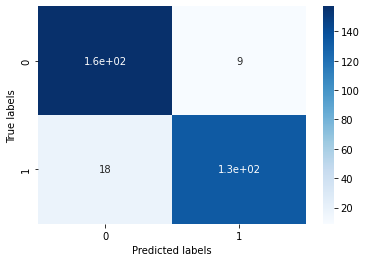

In [25]:
y_pred_binary = np.squeeze(np.round(y_pred))
confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

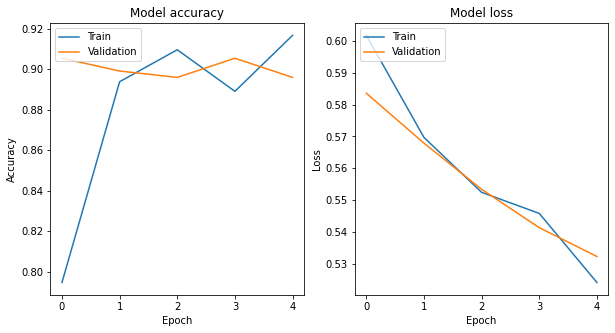

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the training and validation accuracy
ax1.plot(mobileNet_history.history['accuracy'])
ax1.plot(mobileNet_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(mobileNet_history.history['loss'])
ax2.plot(mobileNet_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()


In [27]:
mobilenet_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, mobilenet_pred_binary))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       166
           1       0.94      0.88      0.91       151

    accuracy                           0.91       317
   macro avg       0.92      0.91      0.91       317
weighted avg       0.92      0.91      0.91       317



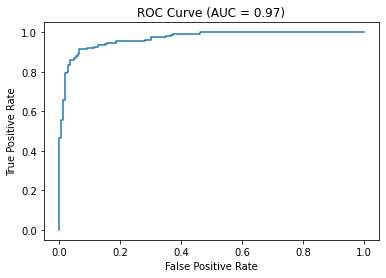

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)
auc_score = roc_auc_score(test_generator.classes, y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()



In [44]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))  
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  
    return img_array

#image_path = r'C:\Users\om\Documents\example\chest_xray\test\NORMAL\IM-0003-0001.jpeg'  
image_path = r'C:\Users\om\Documents\example\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg'  
img_array = load_and_preprocess_image(image_path)


In [45]:
predictions = mobileNet.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 138ms/step
[[0.66142565]]


In [48]:
threshold = 0.5  # Commonly used threshold for binary classification
predicted_class = (predictions[0] > threshold).astype(int)
if predicted_class==1:
    print("Pneumonia")
else:
    print("Normal")

Pneumonia
